# Set up Data

In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


In [4]:
df2 = pd.read_csv('clean_new_well_data_fixed.csv')
num_sample=10000
sampled_df2 = df2.sample(num_sample)
sampled_df2.reset_index(inplace=True,drop=True)
sampled_df2.head()

,id,depth,temp,lat,lon,corrtemp
0,4705900805,1767.6876,48.716667,37.904429,-82.169272,58.251990
1,4700102985,646.9380,30.983333,39.204379,-80.020757,33.211369
2,4705900805,1371.5238,40.900000,37.904429,-82.169272,47.852335
3,4705900811,1379.6010,40.161111,37.572413,-81.844652,47.166110
4,4701900241,2303.9832,75.138889,38.113789,-80.984939,88.170859


In [5]:
# Interpolate Geological Layer information for X
lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)

f = open("optim_result.out", "r")
lines = f.readlines()

optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

# Predict 49 layers information for each sampled_df2 lat and lon
from sklearn.neighbors import KNeighborsRegressor
predicted_mults = []
for i in range(0,49):
    def gaussian_kernel(distances):
                kernel_width = optimal_width[i]
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
    knn = KNeighborsRegressor(n_neighbors=optimal_neigh[i],weights=gaussian_kernel)
    #knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
    knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), mult[:,i])
    y_pred = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))
    predicted_mults.append(y_pred)
    
predicted_mults = np.transpose(np.array(predicted_mults))

# Predict T_SURF
def gaussian_kernel(distances):
            kernel_width = 2.598
            weights = np.exp(-(distances**2)/kernel_width)
            return weights
knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), df.SurfTemp)
predicted_tsurf = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))

In [6]:
# Form X and Y
new_X = np.transpose(np.array([sampled_df2.lat,
                                sampled_df2.lon,
                                sampled_df2.depth,
                                predicted_tsurf]))
new_X = np.concatenate((new_X, predicted_mults),axis=1)
new_Y = sampled_df2.corrtemp.values

# Obtain True Coefficient

In [7]:
uniq_ids = np.unique(sampled_df2.id)

In [8]:
true_coefs = []
for i in uniq_ids:
    sub_df = sampled_df2[sampled_df2.id==i]
    temp_X = sub_df.depth.values.reshape(-1,1)
    temp_y = sub_df.corrtemp.values
    reg = LinearRegression().fit(temp_X, temp_y)
    true_coefs.append(reg.coef_[0])
    #plt.plot(temp_X, temp_y)
    #plt.show()

In [9]:
df_coefs = pd.DataFrame({'ids':uniq_ids, 'true':true_coefs})
#df_coefs

# Physics Model Q Prediction

In [10]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])))
pred_indices = neigh.kneighbors(np.transpose(np.array([sampled_df2.lat,sampled_df2.lon])),return_distance=False)

In [11]:
sampled_df2.insert(6, 'closest',pred_indices)

In [12]:
sampled_df2.reset_index(inplace=True)

In [13]:
min(sampled_df2.depth)

15.3162

In [14]:
predicted_values_by_physics_model = []
for i in range(0, num_sample):
    curr_depth = sampled_df2.depth[i]
    curr_row = df.loc[sampled_df2.closest[i]] # obtain the row
    t_string = 'T'+str(int(curr_depth/10))
    predicted_value = curr_row[t_string]
    predicted_values_by_physics_model.append(predicted_value)

In [15]:
predicted_values_by_physics_model = np.array(predicted_values_by_physics_model)

In [16]:
sampled_df2.insert(8, 'physics_pred', predicted_values_by_physics_model)

In [17]:
phys_coefs = []
for i in uniq_ids:
    sub_df = sampled_df2[sampled_df2.id==i]
    temp_X = sub_df.depth.values.reshape(-1,1)
    temp_y = sub_df.physics_pred.values
    reg = LinearRegression().fit(temp_X, temp_y)
    phys_coefs.append(reg.coef_[0])

In [18]:
df_coefs.insert(2,'phys',phys_coefs)

# Prediction with RF

In [19]:
import pickle
rf = pickle.load(open('finalized_model_RF.sav', 'rb'))
y_pred = rf.predict(new_X)

In [20]:
sampled_df2.insert(9, 'rf_pred', y_pred)

In [21]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,rf_pred
0,0,4705900805,1767.6876,48.716667,37.904429,-82.169272,58.251990,18952,75.8,55.526732
1,1,4700102985,646.9380,30.983333,39.204379,-80.020757,33.211369,16488,33.7,25.134004
2,2,4705900805,1371.5238,40.900000,37.904429,-82.169272,47.852335,18952,57.7,44.917447
3,3,4705900811,1379.6010,40.161111,37.572413,-81.844652,47.166110,20168,45.9,50.012478
4,4,4701900241,2303.9832,75.138889,38.113789,-80.984939,88.170859,17296,51.2,70.284952
...,...,...,...,...,...,...,...,...,...,...
9995,9995,4706100370,1024.4328,34.127778,39.668611,-79.973694,38.817080,18967,30.2,35.266988
9996,9996,4707700458,1064.2092,43.866667,39.523952,-79.615534,48.815311,19054,40.5,41.116586
9997,9997,4705300297,796.8996,23.655556,38.623633,-82.109057,26.861341,16716,34.4,28.578688
9998,9998,4709300105,608.9904,33.022222,39.211063,-79.656463,35.002840,19681,35.8,24.483171


# Prediction with DNN

In [22]:
def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))    
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


model = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=50, verbose=0)
model.fit(X, Y)
y_pred = model.predict(new_X)

In [23]:
sampled_df2.insert(10, 'dnn_pred', y_pred)

In [24]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,rf_pred,dnn_pred
0,0,4705900805,1767.6876,48.716667,37.904429,-82.169272,58.251990,18952,75.8,55.526732,56.892921
1,1,4700102985,646.9380,30.983333,39.204379,-80.020757,33.211369,16488,33.7,25.134004,26.142963
2,2,4705900805,1371.5238,40.900000,37.904429,-82.169272,47.852335,18952,57.7,44.917447,46.822968
3,3,4705900811,1379.6010,40.161111,37.572413,-81.844652,47.166110,20168,45.9,50.012478,47.583885
4,4,4701900241,2303.9832,75.138889,38.113789,-80.984939,88.170859,17296,51.2,70.284952,72.401749
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,4706100370,1024.4328,34.127778,39.668611,-79.973694,38.817080,18967,30.2,35.266988,33.867340
9996,9996,4707700458,1064.2092,43.866667,39.523952,-79.615534,48.815311,19054,40.5,41.116586,36.750320
9997,9997,4705300297,796.8996,23.655556,38.623633,-82.109057,26.861341,16716,34.4,28.578688,29.892912
9998,9998,4709300105,608.9904,33.022222,39.211063,-79.656463,35.002840,19681,35.8,24.483171,25.714218


# Prediction with XGBoost

In [25]:
import pickle
gbm = pickle.load(open('finalized_model_XGB.sav', 'rb'))
y_pred = gbm.predict(new_X)

In [26]:
sampled_df2.insert(11, 'xgb_pred', y_pred)

# Prediction with Ridge

In [27]:
rid = Ridge(alpha = 10)
scaler = StandardScaler()
scaler.fit(X)
rid.fit(X, Y)
y_pred = rid.predict(scaler.transform(new_X))

In [28]:
sampled_df2.insert(12, 'ridge_pred', y_pred)

In [29]:
#sampled_df2.drop('ridge_pred',axis=1,inplace=True)

# Q Predictions

In [30]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,rf_pred,dnn_pred,xgb_pred,ridge_pred
0,0,4705900805,1767.6876,48.716667,37.904429,-82.169272,58.251990,18952,75.8,55.526732,56.892921,54.464474,50.052035
1,1,4700102985,646.9380,30.983333,39.204379,-80.020757,33.211369,16488,33.7,25.134004,26.142963,25.369236,51.515323
2,2,4705900805,1371.5238,40.900000,37.904429,-82.169272,47.852335,18952,57.7,44.917447,46.822968,46.413223,50.029592
3,3,4705900811,1379.6010,40.161111,37.572413,-81.844652,47.166110,20168,45.9,50.012478,47.583885,47.589172,48.003619
4,4,4701900241,2303.9832,75.138889,38.113789,-80.984939,88.170859,17296,51.2,70.284952,72.401749,70.171181,47.797728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,4706100370,1024.4328,34.127778,39.668611,-79.973694,38.817080,18967,30.2,35.266988,33.867340,35.304089,51.201037
9996,9996,4707700458,1064.2092,43.866667,39.523952,-79.615534,48.815311,19054,40.5,41.116586,36.750320,41.329468,52.392265
9997,9997,4705300297,796.8996,23.655556,38.623633,-82.109057,26.861341,16716,34.4,28.578688,29.892912,28.146338,49.914871
9998,9998,4709300105,608.9904,33.022222,39.211063,-79.656463,35.002840,19681,35.8,24.483171,25.714218,29.655825,52.533502


In [31]:
phys_coefs = []
rf_coefs = []
xgb_coefs = []
dnn_coefs = []
ridge_coefs = []
for i in uniq_ids:
    sub_df = sampled_df2[sampled_df2.id==i]
    temp_X = sub_df.depth.values.reshape(-1,1)
    
    ridge_y = sub_df.ridge_pred.values
    reg = LinearRegression().fit(temp_X, ridge_y)
    ridge_coefs.append(reg.coef_[0])
    
    rf_y = sub_df.rf_pred.values
    reg = LinearRegression().fit(temp_X, rf_y)
    rf_coefs.append(reg.coef_[0])
    
    xgb_y = sub_df.xgb_pred.values
    reg = LinearRegression().fit(temp_X, xgb_y)
    xgb_coefs.append(reg.coef_[0])
    
    dnn_y = sub_df.dnn_pred.values
    reg = LinearRegression().fit(temp_X, dnn_y)
    dnn_coefs.append(reg.coef_[0])
    
    #plt.scatter(temp_X, xgb_y)
    #plt.show()

In [32]:
df_coefs.insert(3,'ridge',ridge_coefs)
df_coefs.insert(4,'rf',rf_coefs)
df_coefs.insert(5,'xgb',xgb_coefs)
df_coefs.insert(6,'dnn',dnn_coefs)

In [33]:
df_coefs.head()

,ids,true,phys,ridge,rf,xgb,dnn
0,4700100668,0.035082,0.018357,0.000057,0.029312,0.029248,0.027207
1,4700102985,0.033999,0.033756,0.000057,0.029926,0.030580,0.027917
2,4700501984,0.022333,0.019609,0.000057,0.026074,0.027888,0.027627
3,4700502146,0.028222,0.024227,0.000057,0.028500,0.028167,0.027213
4,4700502148,0.037182,0.030876,0.000057,0.027262,0.027826,0.027237


In [34]:
std = (np.nanstd(abs(df_coefs.true-df_coefs.phys)))
print('phys', m.mean_absolute_error(df_coefs.true, df_coefs.phys),
      m.mean_squared_error(df_coefs.true, df_coefs.phys),std)

std = (np.nanstd(abs(df_coefs.true-df_coefs.ridge)))
print('ridge',m.mean_absolute_error(df_coefs.true, df_coefs.ridge),
      m.mean_squared_error(df_coefs.true, df_coefs.ridge),std)

std = (np.nanstd(abs(df_coefs.true-df_coefs.rf)))
print('rf',m.mean_absolute_error(df_coefs.true, df_coefs.rf),
      m.mean_squared_error(df_coefs.true, df_coefs.rf),std)

std = (np.nanstd(abs(df_coefs.true-df_coefs.xgb)))
print('xgb',m.mean_absolute_error(df_coefs.true, df_coefs.xgb),
      m.mean_squared_error(df_coefs.true, df_coefs.xgb),std)

std = (np.nanstd(abs(df_coefs.true-df_coefs.dnn)))
print('dnn',m.mean_absolute_error(df_coefs.true, df_coefs.dnn),
      m.mean_squared_error(df_coefs.true, df_coefs.dnn),std)

phys 0.006604768542136278 7.465059479535282e-05 0.005570244815101028
ridge 0.027621658439869697 0.0008270873113512502 0.00800820181953636
rf 0.006539846890260186 8.951359846455627e-05 0.0068369584697078895
xgb 0.005616938447342325 6.170991469094865e-05 0.00549180454584067
dnn 0.006969690556726066 7.976179466748127e-05 0.005584371783017746


In [35]:
import seaborn as sns

Text(0.5, 1.0, 'Absolute Error Boxplots for Gradient Prediction')

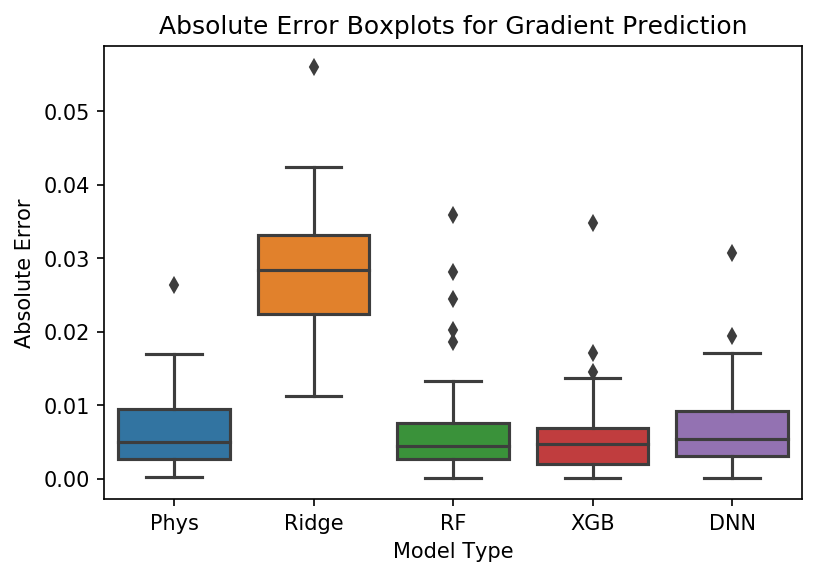

In [36]:
model_type_list = np.array([np.full((58,1),fill_value='Phys'),
                            np.full((58,1),fill_value='Ridge'),
                            np.full((58,1),fill_value='RF'),
                            np.full((58,1),fill_value='XGB'),
                            np.full((58,1),fill_value='DNN')]).flatten()
model_values_list = np.concatenate((abs(df_coefs.true-df_coefs.phys),
                             abs(df_coefs.true-df_coefs.ridge),
                             abs(df_coefs.true-df_coefs.rf),
                             abs(df_coefs.true-df_coefs.xgb),
                             abs(df_coefs.true-df_coefs.dnn)))
df_boxplot = pd.DataFrame({'Model Type':model_type_list, 'Absolute Error':model_values_list})
sns.boxplot(x="Model Type", y="Absolute Error", data=df_boxplot).set_title('Absolute Error Boxplots for Gradient Prediction')